In [1]:
from os.path import join, exists
from os import makedirs
from glob import glob

import numpy as np
import pandas as pd

import pickle

from tqdm import tqdm

import json

from PIL import Image, ImageFilter

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.ticker import MultipleLocator, IndexLocator, FuncFormatter

from nilearn import image, plotting, masking

from joblib import Memory

---

In [2]:
# from core.env import mlagent

In [3]:
# from torchvision import transforms

# convert_tensor = transforms.ToTensor()

In [4]:
import torch

# device = "cuda:1" if torch.cuda.is_available() else "cpu"
device = 'cpu'
device

'cpu'

In [75]:
dir_root = '/mnt/ext5/DRN'

dir_behav = join(dir_root, 'behav_data')

dir_fmri = join(dir_root,'fmri_data')
dir_mask = join(dir_fmri, 'masks')
dir_model = join(dir_root,'model')

---

In [6]:
scaler = StandardScaler()

(-4.4112861511772885e-16, 0.9999999999999998)

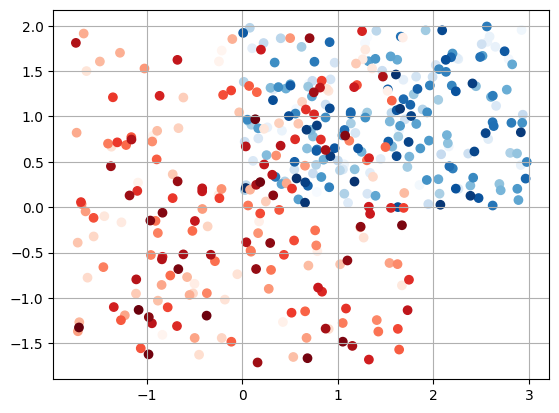

In [7]:
N = 200

tmp = np.concatenate(
    [np.random.rand(N,1)*3, np.random.rand(N,2)*2],
    axis=1
)

palette = cm.Blues(np.linspace(0,1,N))
plt.scatter(tmp[:,0],tmp[:,1], c=palette)

tmp = scaler.fit_transform(tmp)
palette = cm.Reds(np.linspace(0,1,N))
g = plt.scatter(tmp[:,0],tmp[:,1], c=palette)

plt.grid()

tmp.mean(), tmp.std()

---

In [8]:
def state_processing(obs):
    vis_obs = []

    for _obs in obs:
        ## _obs.shape = (1, 72, 128, 3)
        vis_obs.append(_obs)

    ## visual observation [(1, 72, 128, 3) x 4]
    vis_obs = np.concatenate(vis_obs, axis=-1)
    ## visual observation (1, 72, 128, 12)
    vis_obs = np.transpose(vis_obs, (0, 3, 1, 2))
    vis_obs = (vis_obs * 255).astype(np.uint8)
    
    ## visual observation (1, 12, 72, 128)
    return vis_obs

In [9]:
def convert_time_to_sec(Time):
    m, s, ds = np.array(Time.split('-')).astype(int)
    return m*60+s+0.001*ds

---

In [10]:
## time points per a run
TR = 0.5
TPs = 1400 - 12

In [11]:
subj = 'DRN04'

---

### behavioral data

In [12]:
def get_data_behav(subj, resolution=(128,72)):
    
    dir_work = join(dir_behav,subj,'resized_%dx%d'%(resolution[0],resolution[1]))
    list_run = ['Run%d'%(ii+1) for ii in range(6)]
    
    ## i) Screen Shots
    list_png = {}
    ## ii) Actions
    behav = {}
    ## iii) onset times
    list_onsettime = {}
    ## iv) episode
    list_episode = {}
    for run in list_run:
        ## i)
        list_png[run] = np.array(sorted(glob(join(dir_work,run,'*.png'))))
        ## ii)
        with open(join(dir_work,run,'log.json'),'r') as f:
            behav[run] = json.load(f)
#         print('%s: actions (%d) / pngs (%d)'%(run, len(behav[run]), len(list_png[run])))

        ## iii)
        tmp = []
        ### iv)
        tmp2 = []
        for dict_ in behav[run]:
            tmp.append(convert_time_to_sec(dict_['Time']))
            tmp2.append(dict_['Episode'])
        list_onsettime[run] = np.array(tmp)
        list_episode[run] = np.array(tmp2)
    
    return list_png, list_onsettime, list_episode

In [13]:
list_png, list_onsettime, list_episode = get_data_behav(subj)

(72, 128, 3)

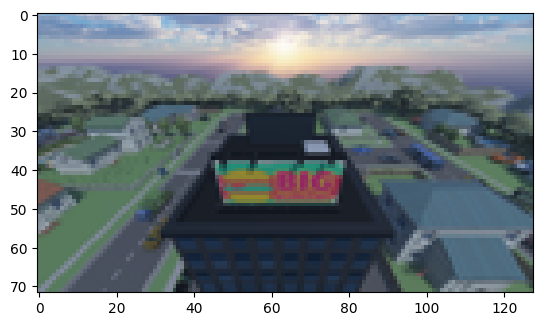

In [14]:
img = Image.open(list_png['Run1'][0])
plt.imshow(img)
np.asarray(img).shape

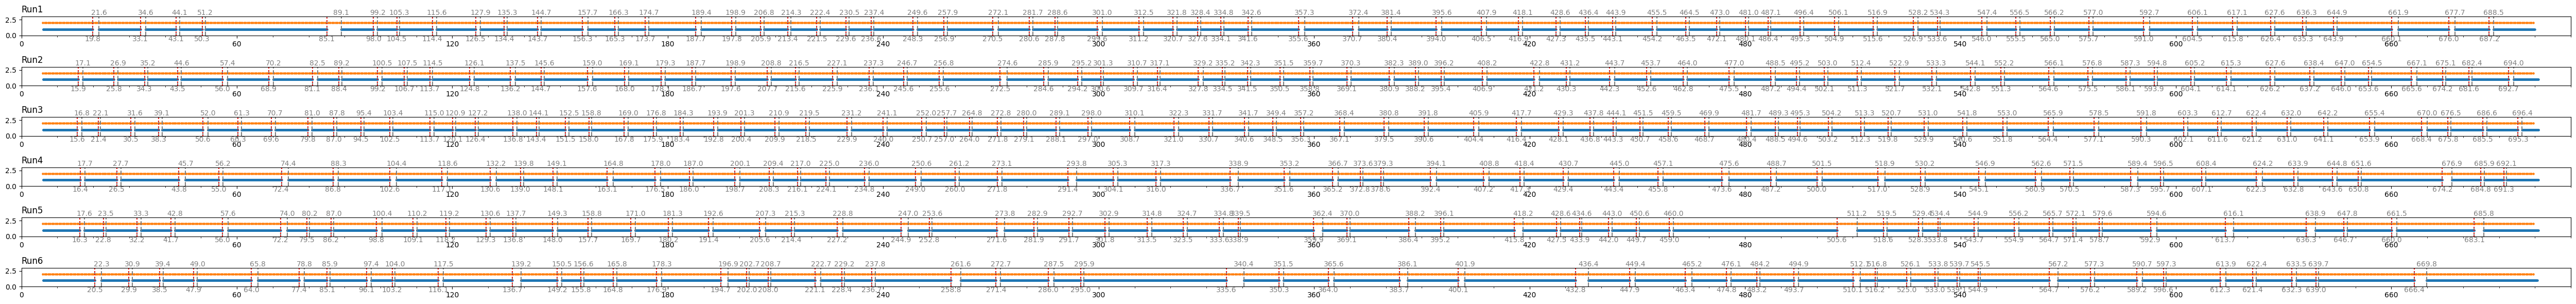

In [15]:
fig, axs = plt.subplots(nrows=6, figsize=(50,6))

for ii, run in enumerate(['Run%1d'%(rr+1) for rr in range(6)]):
    ax = axs[ii]
    
    ## frames
    x = list_onsettime[run]
    y = np.ones(len(x))
    ax.scatter(x,y,s=10,linewidths=0.1)
    ax.set_xlim(0,710)
    ax.xaxis.set_major_locator(MultipleLocator(60))
    ax.xaxis.set_major_formatter('{x:.0f}')
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    
    idx_gap = np.where(np.diff(x)>0.4)[0]
    for idx in idx_gap:
        ax.vlines(x=x[idx], ymin=0, ymax=3, color='gray', linestyle='--')
        ax.text(
            x[idx], 0, '%.1f'%x[idx],
            va='top', ha='center',
            color='gray'
        )
        ax.vlines(x=x[idx+1], ymin=0, ymax=3, color='gray', linestyle='--')
        ax.text(
            x[idx+1], 3, '%.1f'%x[idx+1],
            va='bottom', ha='center',
            color='gray'
        )

    ## episode
    idx_end = np.where(np.diff(list_episode[run]))
    for idx in idx_end:
        ax.vlines(x=x[idx], ymin=0, ymax=3, color='red', linestyle=':')

    ## fMRI
    ax.scatter(np.arange(6,700,0.5),2*np.ones(TPs),s=10,linewidths=0.1)
    ax.set_ylim(0,3)
    
    ax.set_title(run, loc='left')

fig.tight_layout()

---

In [16]:
def get_idx_input(subj, run, shift=0):
    nFrameStack = 4
    TR = 0.5
    
    _, list_onsettime, _ = get_data_behav(subj)

    onsettimes = list_onsettime[run]
    onsettimes = onsettimes[onsettimes<700-shift]

    ## A set of the last indices for each episode except the last episode
    idx_final = np.concatenate([np.where(np.diff(onsettimes)>TR)[0], [onsettimes.shape[0]-1]])
    idx_initial = np.concatenate([[0],idx_final[:-1]+1])
    assert idx_initial.shape == idx_final.shape

    idx_input = {}
    idx_epi = {}
    for ii, (idx_i, idx_f) in enumerate(zip(idx_initial, idx_final)):
        episode = 'episode:%02d'%(ii+1)

        ## the times of the initial and final frame
        ta, tb = onsettimes[idx_i], onsettimes[idx_f]
        ## the number of frames at the episode
        n_frame = int(idx_f-idx_i+1)

        ## The fMRI image corresponding to the first frame of this episode
        a = ta - ta%TR
        ## The fMRI image corresponding to the final frame of this episode
        b = tb - tb%TR

        ## The number of fMRI images representing the corresponding episode.
        n_epi = int((b-a)/TR + 1)
        if n_epi <= 1:
            continue

        ## The fMRI indices that make up each episode
        timepoint_epi = np.arange(a,b+TR,TR)+shift
        timepoint_epi = timepoint_epi[timepoint_epi<700]
        idx_epi[episode] = (2*(timepoint_epi-6)).astype(int)

        ## an input set to forward via a model
        idx_input[episode] = np.zeros((n_epi,nFrameStack)).astype(int)

        ## the last input
        idx_input[episode][-1] = [idx_f-nFrameStack+1+jj for jj in range(nFrameStack)]

        ## the rest of them
        didx = (idx_f-nFrameStack-idx_i)*TR/(b-a+1.e-8)
        for jj in range(n_epi-1):
            idx_input[episode][jj] = [int(idx_i+didx*jj+kk) for kk in range(nFrameStack)]

    for episode, input_ in idx_input.items():
        assert input_.shape[0] == idx_epi[episode].shape[0]
    
    return idx_input, idx_epi

---

In [17]:
def plot_episode(subj, run, shift):
    
    _, list_onsettime, _ = get_data_behav(subj)
    idx_input, idx_epi = get_idx_input(subj=subj, run=run, shift=shift)

    fig, ax = plt.subplots(nrows=1, figsize=(50,2))

    ax.vlines(x=6, ymin=0, ymax=3, color='black', linestyle='--')
    ax.text(
        6, 0, '%.1f'%6,
        va='top', ha='center',
        color='gray'
    )
    for epi, idx2Dset in idx_input.items():
        list_idx = idx2Dset.reshape(-1)

        ## frames
        x = list_onsettime[run][list_idx]
        y = np.ones(len(x))
        ax.scatter(x,y,s=10,linewidths=0.1)

        ax.vlines(x=x[-1], ymin=0, ymax=1, color='gray', linestyle='--')
        ax.text(
            x[-1], 0, '%.1f'%x[-1],
            va='top', ha='center',
            color='gray'
        )

        ## fMRI
        x = np.arange(6,700+shift,0.5)[idx_epi[epi]]
        y = np.ones(len(x))*2
        ax.scatter(x,y,s=10,linewidths=0.1)

        ax.vlines(x=x[-1], ymin=2, ymax=3, color='gray', linestyle='--')
        ax.text(
            x[-1], 3, '%.1f'%x[-1],
            va='bottom', ha='center',
            color='gray'
        )

    ax.set_xlim(0,710)
    ax.xaxis.set_major_locator(MultipleLocator(60))
    ax.xaxis.set_major_formatter('{x:.0f}')
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.set_ylim(0,3)
    ax.set_yticklabels([0,'Frames','BOLD',3])

    ax.set_title('%s (%.1fs shifted)'%(run,shift), loc='left')

    fig.tight_layout()

/tmp/ipykernel_1048727/1984994176.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,'Frames','BOLD',3])


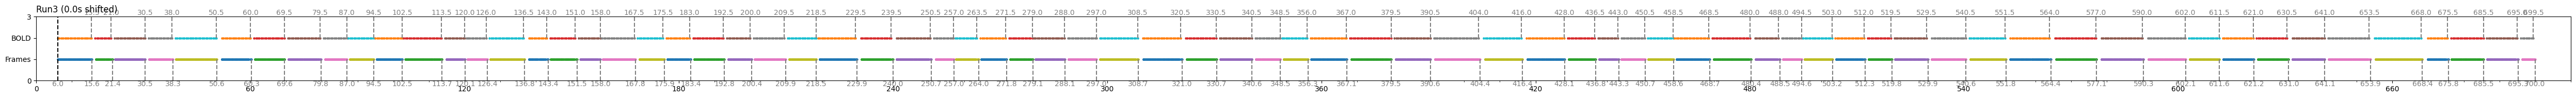

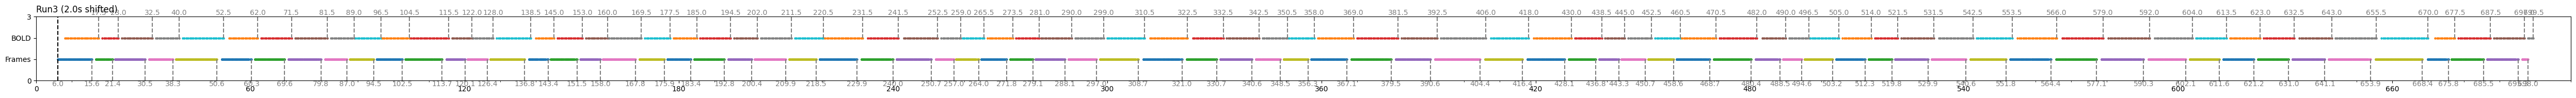

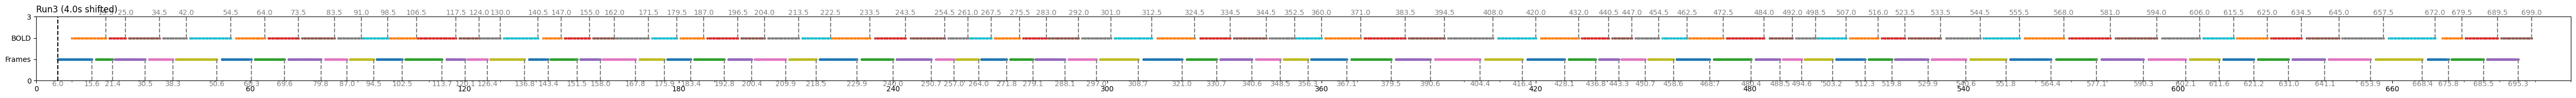

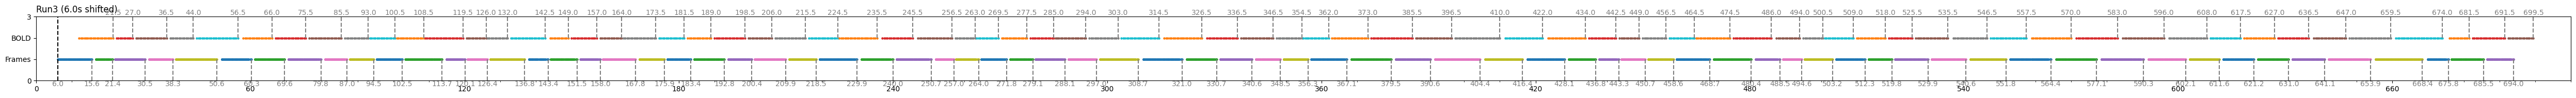

In [18]:
run = 'Run3'
for shift in [0, 2, 4, 6]:
    plot_episode(subj,run,shift)

---

the config

In [19]:
with open(join(dir_model,'drone_hanyang_mlagent.ppo/drone_hanyang_mlagent.json'),'r') as f:
    hanyang = json.load(f)
hanyang

{'env': {'name': 'drone_hanyang_mlagent', 'render': 'True', 'time_scale': 3.0},
 'agent': {'name': 'ppo',
  'network': 'continuous_policy_value',
  'head': 'cnn',
  'gamma': 0.95,
  'batch_size': 32,
  'n_step': 128,
  'n_epoch': 3,
  '_lambda': 0.95,
  'epsilon_clip': 0.1,
  'vf_coef': 1.0,
  'ent_coef': 0.01,
  'clip_grad_norm': 1.0,
  'use_standardization': 'True',
  'lr_decay': 'False'},
 'optim': {'name': 'adam', 'lr': 0.00025},
 'train': {'training': 'True',
  'load_path': './logs/drone_hanyang_mlagent/ppo/20230311094756544355/',
  'run_step': 30000000,
  'print_period': 10000,
  'save_period': 500000,
  'eval_iteration': 3,
  'record': 'False',
  'record_period': 1000000,
  'distributed_batch_size': 256,
  'update_period': "agent['n_step']",
  'num_workers': 5}}

## load pretrained parameters

In [20]:
ckpt = torch.load(
    join(dir_model,'drone_hanyang_mlagent.ppo/level2.ckpt')
    , map_location=device
)

In [21]:
for key1, dict_ in ckpt.items():
    print('################')
    print(key1)
    print('################')
    for key2, value in dict_.items():
        if type(value) is not dict:
            print('%s\n%s\n'%(key2,value.shape))
        else:
            break

################
network
################
head.conv1.weight
torch.Size([32, 12, 8, 8])

head.conv1.bias
torch.Size([32])

head.conv2.weight
torch.Size([64, 32, 4, 4])

head.conv2.bias
torch.Size([64])

head.conv3.weight
torch.Size([64, 64, 3, 3])

head.conv3.bias
torch.Size([64])

l.weight
torch.Size([512, 3840])

l.bias
torch.Size([512])

mu.weight
torch.Size([3, 512])

mu.bias
torch.Size([3])

log_std.weight
torch.Size([3, 512])

log_std.bias
torch.Size([3])

v.weight
torch.Size([1, 512])

v.bias
torch.Size([1])

################
optimizer
################


---

# Encoding model

#### Network

In [22]:
from core.network import *

InputShape = (12,72,128)
network = policy_value.ContinuousPolicyValue(D_in=InputShape, D_out=3, D_hidden=512, head='cnn')
network.eval().to(device)

ContinuousPolicyValue(
  (head): CNN(
    (conv1): Conv2d(12, 32, kernel_size=(8, 8), stride=(4, 4))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (l): Linear(in_features=3840, out_features=512, bias=True)
  (mu): Linear(in_features=512, out_features=3, bias=True)
  (log_std): Linear(in_features=512, out_features=3, bias=True)
  (v): Linear(in_features=512, out_features=1, bias=True)
)

In [23]:
input_ = torch.rand((5,*InputShape))
print(input_.shape)
(mu, std, v), (conv1, conv2, conv3) = network(input_.to(device))

conv1.shape, conv2.shape, conv3.shape, mu.shape, std.shape, v.shape

torch.Size([5, 12, 72, 128])


(torch.Size([5, 32, 17, 31]),
 torch.Size([5, 64, 7, 14]),
 torch.Size([5, 64, 5, 12]),
 torch.Size([5, 3]),
 torch.Size([5, 3]),
 torch.Size([5, 1]))

#### copy parameters `network.head.weight = torch.nn.Parameter(ckpt['network'].head)`

In [24]:
network.load_state_dict(ckpt['network'])

<All keys matched successfully>

---

In [25]:
n_components = 200
pipeline_pca = Pipeline(
    [
        ('scaling', StandardScaler()),
        ('pca', PCA(n_components=n_components))
    ]
)
pipeline_pca

Pipeline(steps=[('scaling', StandardScaler()), ('pca', PCA(n_components=200))])

In [26]:
def do_forward(subj, run, shift=0):
    ## ======================= setup ======================= ##
    list_png, _, _ = get_data_behav(subj)
    idx_input, idx_epi = get_idx_input(subj=subj, run=run, shift=shift)

    for ii, (episode, indices) in enumerate(idx_epi.items()):
        ## 해당 EPI index에 매칭되는 png의 index들
        tmp = idx_input[episode]

        ## 해당 RUN에 input으로 쓰일 모든 png fname 들
        if ii > 0:
            input_fname = np.concatenate(
                [
                    input_fname,
                    list_png[run][tmp]
                ],
                axis=0
            )
        else:
            input_fname = list_png[run][tmp]

    ## (batch size of Run, 4)
    (batch, _) = input_fname.shape

    ## ======================= input ======================= ##
    ## Actual input values to be entered into the network
    input_ = np.zeros((batch,12,72,128), dtype=np.uint8)

    for timepoint, fnames in enumerate(tqdm(input_fname)):
        ## 4 frames (1,72,128,3) 를 numpy 로 불러와서 쌓음
        tmp = np.stack(
            [np.asarray(Image.open(f)).reshape((1,72,128,3)) for f in fnames],
            axis=0
        )

        ## 이미지 전처리 (4, 1, 72, 128, 3) -> (12, 72, 128, 3)
        input_[timepoint] = state_processing(tmp)

    del tmp
    ## 이미지를 torch.tensor 로 변경
    input_ = torch.from_numpy(input_)
    ## ========================== Forward ========================== ##
    ## 쌓은 frame 들을 network에 입력
    with torch.no_grad():
        output_ = network(input_.to(device))

    return output_

#### Make matrix X

In [27]:
dir_cache = join(dir_root,'cache/X')
makedirs(dir_cache, exist_ok=True)

memory = Memory(dir_cache, verbose=0)

@memory.cache
def myfunc_X(subj):
    ## design matrix X를 구성할 PC 열벡터들
    X = {}
    for run in ['Run%1d'%(ii+1) for ii in range(6)]:
        for shift in [4, 4.5, 5, 5.5, 6]:
            ## time shift 를 고려하여 추려낸, 분석 가능한 EPI indices
            _, idx_epi = get_idx_input(subj=subj, run=run, shift=shift)
            row = np.concatenate(list(idx_epi.values()))
            
            ## ======================== forward ======================== ##
            output_ = do_forward(subj, run, shift)
            (mu, std, v), (conv1, conv2, conv3) = output_

            del output_
            ## ========================== PCA ========================== ##
            for jj, layer in enumerate([conv1, conv2, conv3]):
                lname = 'conv%1d'%(jj+1)
                key = (run,lname,shift)

                nsamples = layer.shape[0]
                nfeatures = np.prod(layer.shape[1:])

                PCs = pipeline_pca.fit_transform(layer.reshape(nsamples,nfeatures))

                ## 위 index들 외의 index들은 분석 불가능하므로, feature들을 0으로 둔다
                tmp = np.zeros((TPs, n_components))

                ## 얻어낸 index 에 맞게 PC들을 매칭하여 부분적인 X를 완성시킨다
                tmp[row] = PCs
                X[key] = tmp
                del tmp
            
    return X

In [28]:
X = myfunc_X(subj)

100%|██████████| 1276/1276 [00:01<00:00, 676.59it/s]


In [29]:
for key, val in X.items():
    print(key, val.shape)

('Run1', 'conv1', 4) (1388, 200)
('Run1', 'conv2', 4) (1388, 200)
('Run1', 'conv3', 4) (1388, 200)
('Run1', 'conv1', 4.5) (1388, 200)
('Run1', 'conv2', 4.5) (1388, 200)
('Run1', 'conv3', 4.5) (1388, 200)
('Run1', 'conv1', 5) (1388, 200)
('Run1', 'conv2', 5) (1388, 200)
('Run1', 'conv3', 5) (1388, 200)
('Run1', 'conv1', 5.5) (1388, 200)
('Run1', 'conv2', 5.5) (1388, 200)
('Run1', 'conv3', 5.5) (1388, 200)
('Run1', 'conv1', 6) (1388, 200)
('Run1', 'conv2', 6) (1388, 200)
('Run1', 'conv3', 6) (1388, 200)
('Run2', 'conv1', 4) (1388, 200)
('Run2', 'conv2', 4) (1388, 200)
('Run2', 'conv3', 4) (1388, 200)
('Run2', 'conv1', 4.5) (1388, 200)
('Run2', 'conv2', 4.5) (1388, 200)
('Run2', 'conv3', 4.5) (1388, 200)
('Run2', 'conv1', 5) (1388, 200)
('Run2', 'conv2', 5) (1388, 200)
('Run2', 'conv3', 5) (1388, 200)
('Run2', 'conv1', 5.5) (1388, 200)
('Run2', 'conv2', 5.5) (1388, 200)
('Run2', 'conv3', 5.5) (1388, 200)
('Run2', 'conv1', 6) (1388, 200)
('Run2', 'conv2', 6) (1388, 200)
('Run2', 'conv3', 6

---

#### Perform GLM (Generalized Linear Model) with the value function.

In [76]:
dir_reg = join(dir_behav, 'regressors/AM/value')

100%|██████████| 1288/1288 [00:01<00:00, 681.50it/s]


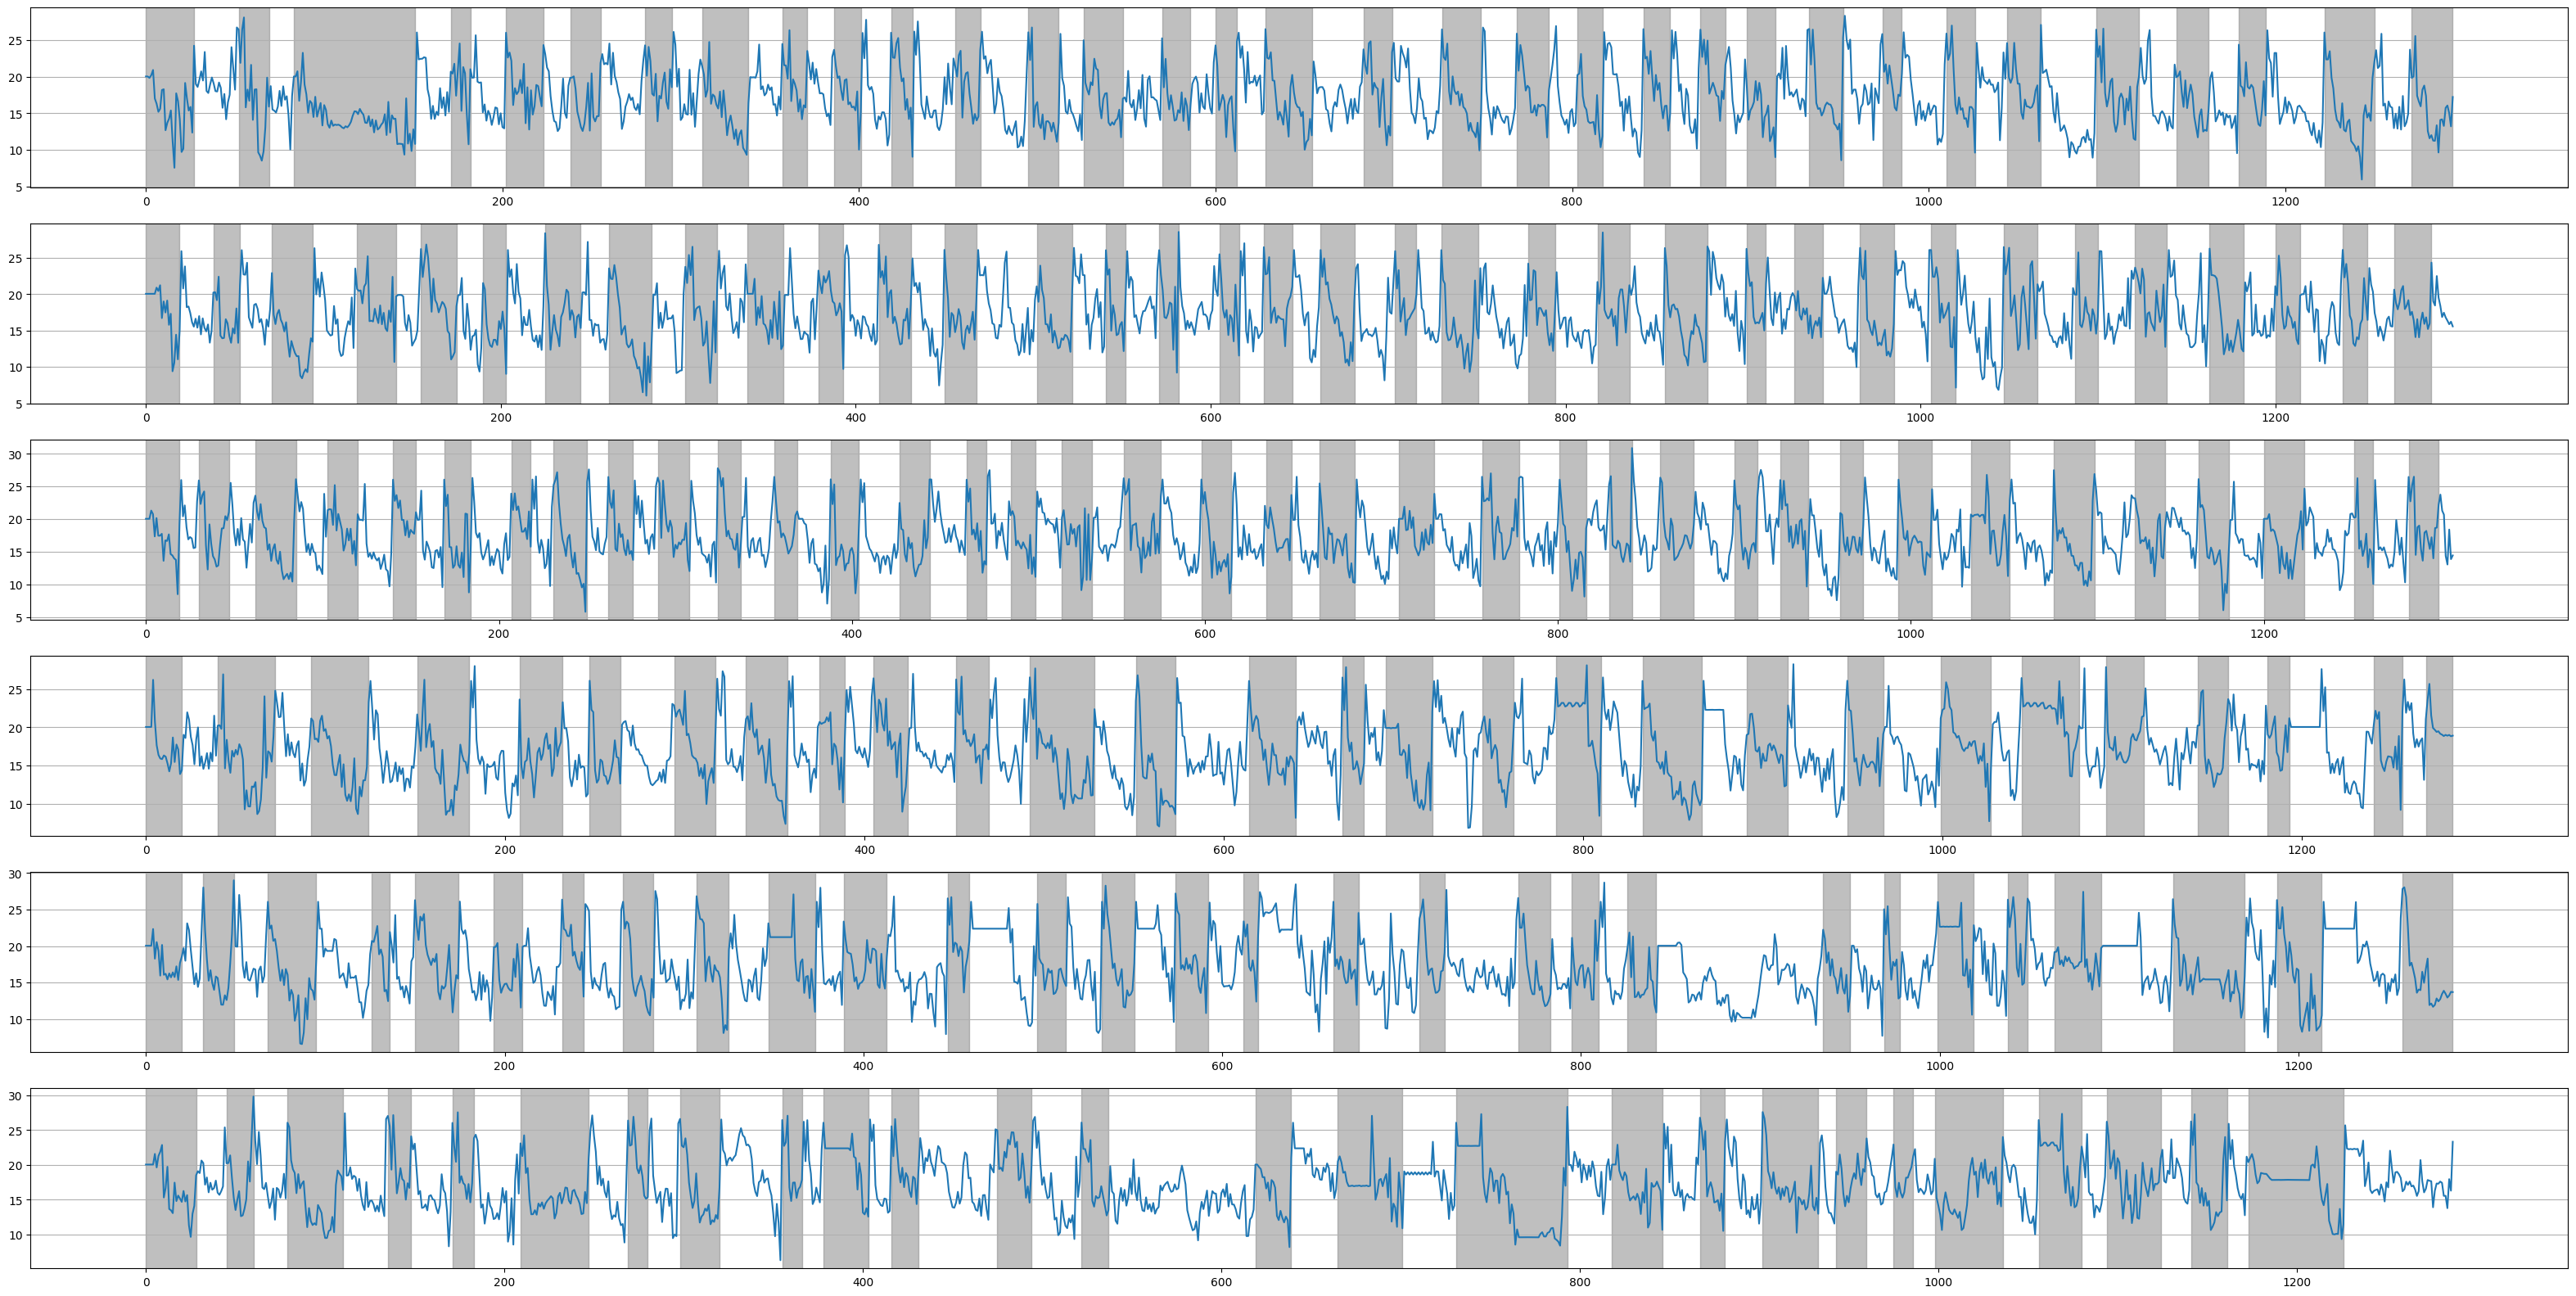

In [104]:
fig, axs = plt.subplots(nrows=6, figsize=(40,20))

_, list_onsettime, list_episode = get_data_behav(subj)
for rr, (run, onset) in enumerate(list_onsettime.items()):
    ## onsettime
    idx_input, idx_epi = get_idx_input(subj=subj, run=run, shift=0)
    for ii, (key, val) in enumerate(idx_input.items()):
        if ii > 0:
            list_idx = np.concatenate([list_idx, val[:,0]])
        else:
            list_idx = val[:,0]
    ## episode
    episode = list_episode[run][list_idx]
    
    ## value function
    (_,_,value),(_,_,_) = do_forward(subj, run, shift=0)
    value = np.squeeze(value.numpy())
    
    ## plot
    ax = axs[rr]
    x = range(len(value))
    ax.plot(x,value)
    ylim = ax.get_ylim()
    ax.grid(axis='y')
    ax.fill_between(
                x=x,
                y1=0, y2=40,
                where=(episode%2==0),
                color='gray', alpha=0.5
            )
    ax.set_ylim(ylim)
    
    ## make regressor
    reg = []
    for onset_, value_ in zip(onset[list_idx], value):
        reg.append('%.2f*%.3f'%(onset_,value_))
    reg = np.array(reg)
    
    # save the result
    np.savetxt(
        join(dir_reg, '%s.r%02d.value.txt'%(subj,rr+1)),
        X=reg,
        fmt='%s', delimiter=' ', newline=' '
    )

---

check one of the output

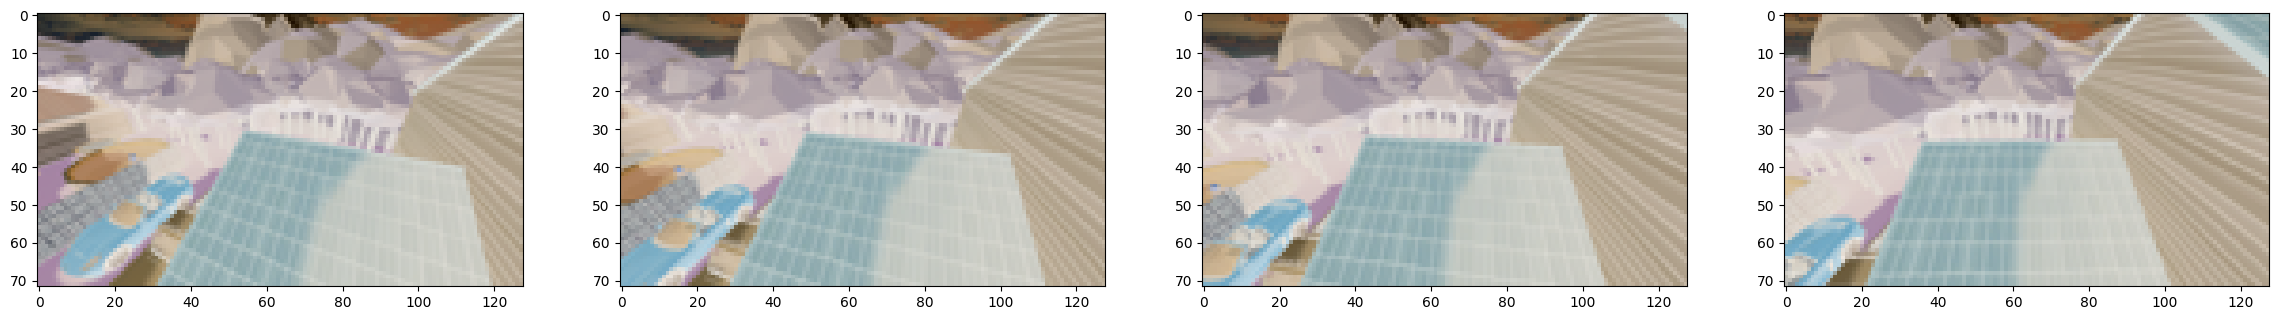

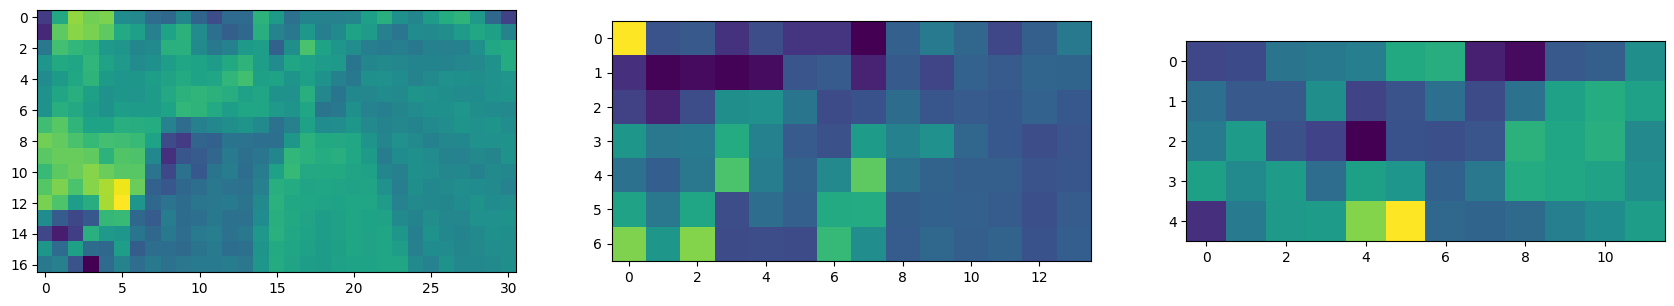

In [30]:
batch=1

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(7.2*4, 12.8))
for ii in range(4):
    ax = axs[ii]
    
    input_fname = list_png['Run1'][100:104]

    ## Actual input values to be entered into the network
    input_ = np.zeros((batch,12,72,128), dtype=np.uint8)
    
    ## 4 frames (1,72,128,3) 를 numpy 로 불러와서 쌓음
    tmp = np.stack(
        [np.asarray(Image.open(f)).reshape((1,72,128,3)) for f in input_fname],
        axis=0
    )

    ## 이미지 전처리 (4, 1, 72, 128, 3) -> (1, 12, 72, 128)
    input_ = state_processing(tmp)
    img = input_[0][ii*3:(ii+1)*3]
    ax.imshow(np.transpose(img,(1,2,0)))

    ## 이미지를 torch.tensor 로 변경
    input_ = torch.from_numpy(input_)
    
    ## 쌓은 frame 들을 network에 입력
    with torch.no_grad():
        output_ = network(input_.to(device))
    (mu, std, v), (conv1, conv2, conv3) = output_
    
_, axs = plt.subplots(ncols=3, figsize=(21,7))
axs[0].imshow(conv1.numpy().mean(axis=(0,1)))
axs[1].imshow(conv2.numpy().mean(axis=(0,1)))
axs[2].imshow(conv3.numpy().mean(axis=(0,1)))

check the parameter invariance

In [31]:
# network.head.conv1.weight == ckpt['network']['head.conv1.weight']

conv1

(1388, 200)
(1388, 200)


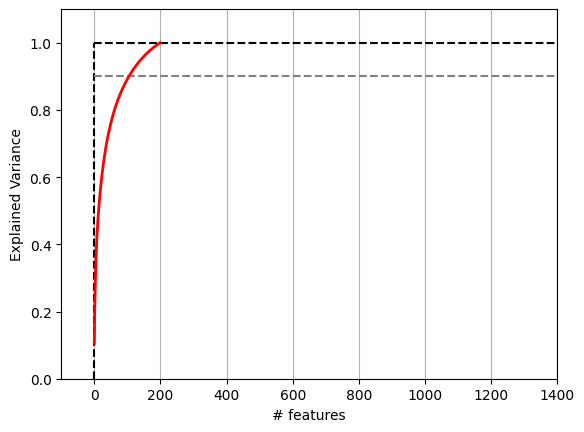

In [32]:
conv1 = X[('Run1','conv1',4)]
print(conv1.shape)
nsamples = conv1.shape[0]
nfeatures = np.prod(conv1.shape[1:])

pca = PCA(n_components=n_components)
PCs = pca.fit_transform(conv1.reshape(nsamples,nfeatures))
print(PCs.shape)

plt.hlines(y=1., xmin=0, xmax=2000, color='black', linestyles='--')
plt.vlines(x=0., ymin=-0, ymax=1, color='black', linestyles='--')
plt.hlines(y=0.9, xmin=0, xmax=2000, color='gray', linestyles='--')

plt.plot(np.cumsum(pca.explained_variance_ratio_), color='red', linewidth=2.)

plt.xlabel('# features')
plt.ylabel('Explained Variance')
plt.xlim(-100,1400)
plt.ylim(0,1.1)
plt.grid(axis='x')

---

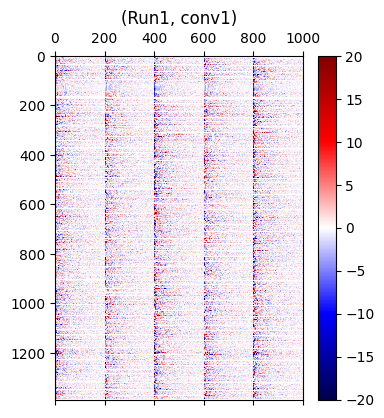

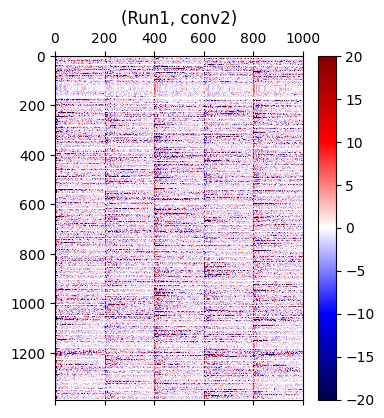

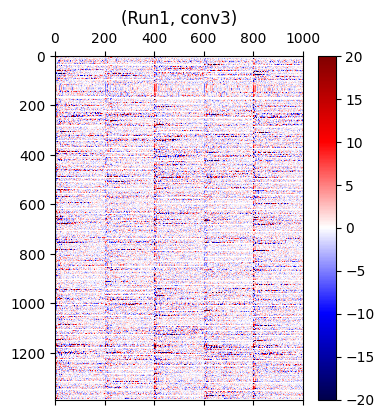

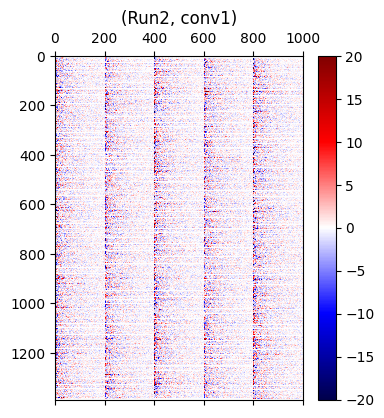

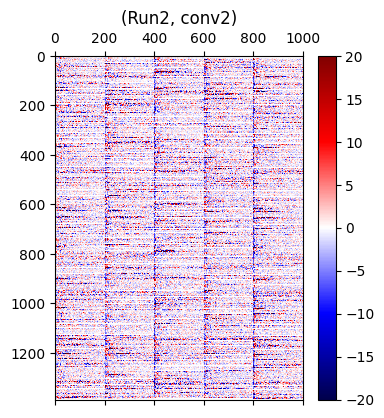

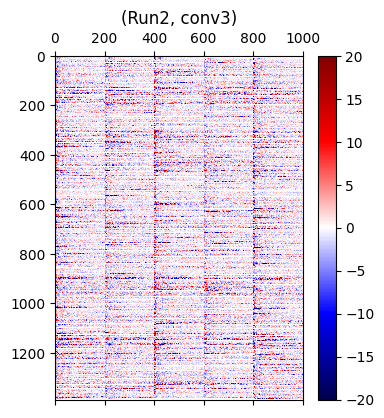

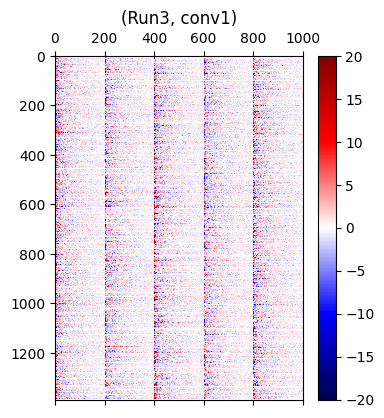

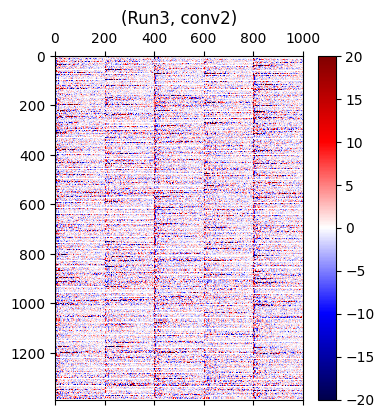

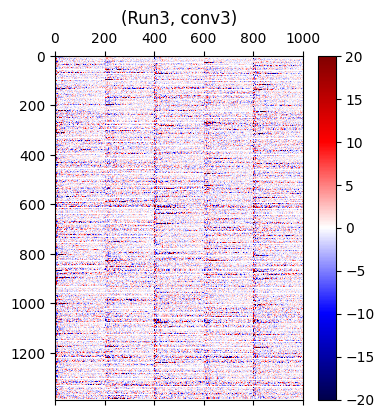

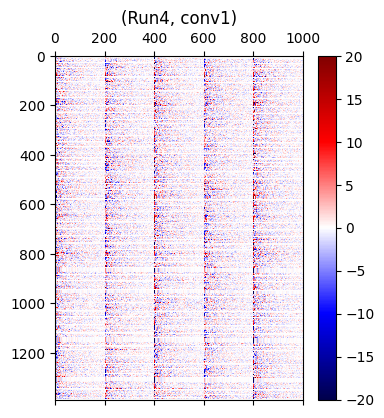

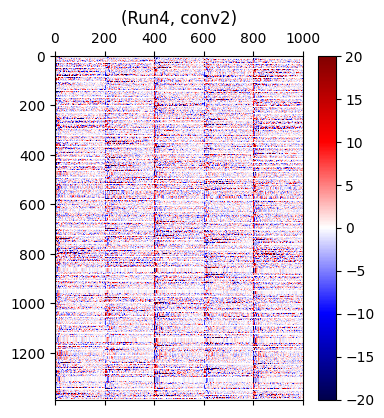

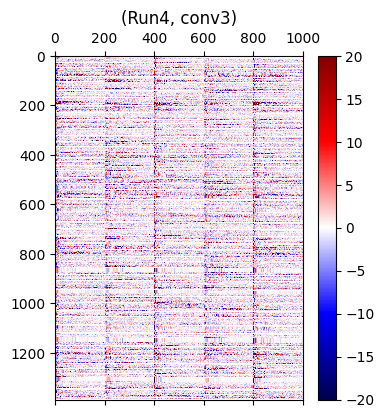

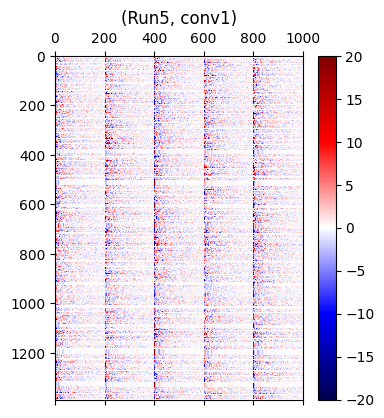

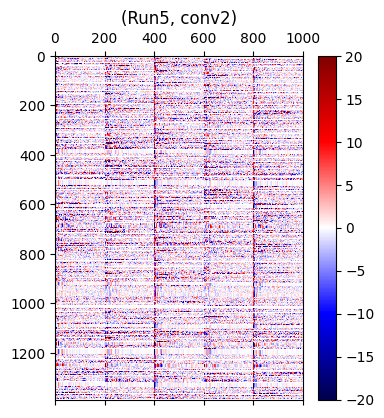

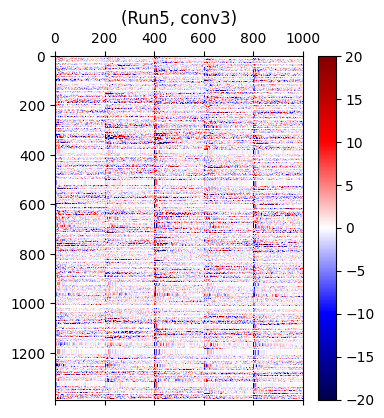

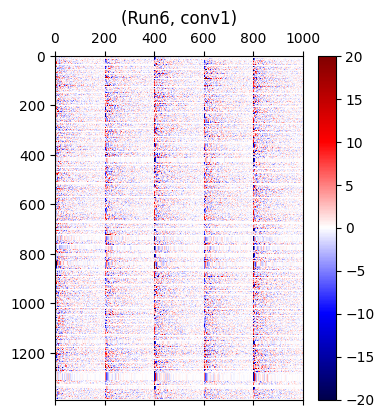

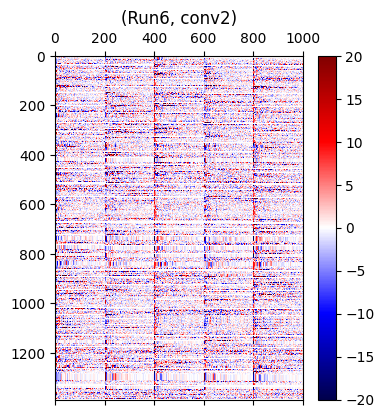

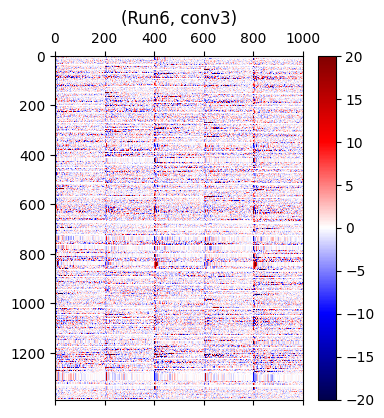

In [33]:
Xmat = {}
for run in ['Run%1d'%(ii+1) for ii in range(6)]:
    for layer in ['conv%1d'%(ii+1) for ii in range(3)]:
        tmp = np.ones((TPs,1))
        for ii, shift in enumerate([4, 4.5, 5, 5.5, 6]):
            tmp = np.concatenate(
                [tmp, X[(run,layer,shift)]],
                axis=1
            )
        Xmat[(run,layer)] = tmp
        plt.matshow(
            Xmat[(run,layer)],
            cmap=cm.seismic, vmin=-20, vmax=20
        )
        plt.title('(%s, %s)'%(run,layer))
        plt.colorbar(shrink=0.8, aspect=20)
del X

In [34]:
X = {}
for layer in ['conv%1d'%(ii+1) for ii in range(3)]:
    print(layer)
    for ii, run in enumerate(['Run%1d'%(ii+1) for ii in range(6)]):
        if ii==0:
            tmp = Xmat[(run,layer)]
        else:
            tmp = np.concatenate(
                [tmp, Xmat[(run,layer)]],
                axis = 0
            )
    X[layer] = tmp
    print(tmp.shape)

del Xmat, tmp

conv1
(8328, 1001)
conv2
(8328, 1001)
conv3
(8328, 1001)


---

### fMRI data

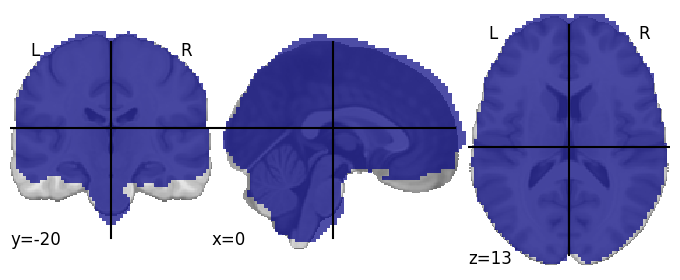

In [39]:
mask = join(dir_mask,'mask.group.n3.frac=0.7.nii')
plotting.plot_roi(mask)

In [40]:
dir_cache = join(dir_root,'cache/apply_mask')
makedirs(dir_cache, exist_ok=True)

memory = Memory(dir_cache, verbose=0)

@memory.cache
def myfunc_apply_mask(subj):
    Y = masking.apply_mask(
        imgs = join(dir_fmri,'preproc_data',subj,'errts.%s.volreg.tproject.nii'%subj),
        mask_img = mask
    )
    
    (_, nvoxels) = Y.shape

    ## reshape
    Y = Y.reshape(6,TPs,nvoxels)

    ## normalization performed for each RUN
    for ii, run in enumerate(['Run%1d'%(ii+1) for ii in range(6)]):
        if ii==0:
            tmp = scaler.fit_transform(Y[ii])
        else:
            tmp = np.concatenate(
                [tmp, scaler.fit_transform(Y[ii])],
                axis=0
            )
    Y = tmp
    
    return Y.reshape(6, TPs, nvoxels)

In [41]:
Y = myfunc_apply_mask(subj)
Y.shape

(6, 1388, 113158)

In [42]:
# plt.matshow(Y[0], cmap=cm.seismic)
# plt.colorbar(shrink=0.8, aspect=20)

Save the result as .nii

In [43]:
dir_work = join(dir_fmri,'encoding_model',subj)
makedirs(dir_work, exist_ok=True)

In [44]:
for rr, run in enumerate(tqdm(['Run%1d'%(ii+1) for ii in range(6)])):
    fname = join(dir_work,'Y.r%02d.nii'%(rr+1))
    if not exists(fname):
        img = masking.unmask(
            X = Y[rr],
            mask_img = join(dir_mask,'mask.group.n3.frac=0.7.nii')
        )
        img.to_filename(fname)

100%|██████████| 6/6 [00:00<00:00, 89240.51it/s]


---

#### Ridge Regression

In [45]:
from himalaya.ridge import RidgeCV

clf = RidgeCV(alphas=np.logspace(start=2,stop=12,num=11))
kf = KFold(n_splits=6, random_state=None, shuffle=False)

In [48]:
from himalaya.backend import set_backend

# backend = set_backend('torch_cuda', on_error='warn')
backend = set_backend('cpu', on_error='warn')
print(backend)

<module 'himalaya.backend.numpy' from '/home/sungbeenpark/anaconda3/envs/DRN/lib/python3.9/site-packages/himalaya/backend/numpy.py'>


/home/sungbeenpark/anaconda3/envs/DRN/lib/python3.9/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to cpu failed: Unknown backend='cpu'.Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [52]:
## preprocessing X
tmp = X[layer]
tmp = tmp.reshape(6,TPs,-1)
print(tmp.shape)

# preprocessing Y
Y = myfunc_apply_mask(subj)
print(Y.shape)

## initializing Y_pred
Y_pred = np.zeros(Y.shape)
print(Y_pred.shape)

## learning
for idx_train, idx_test in kf.split(['Run%1d'%(ii+1) for ii in range(6)]):
    if idx_test[0]!=0:
        continue
        
    print(idx_train, idx_test)
    ## Training set
    X_train = np.concatenate(tmp[idx_train], axis=0)
    Y_train = np.concatenate(Y[idx_train], axis=0)
    
    ## TO speed up model fitting on GPU
    X_train = X_train.astype('float32')
    Y_train = Y_train.astype('float32')
    
    ## Training
    _ = clf.fit(X_train, Y_train)

    ## Test set
    X_test = tmp[idx_test[0]]
    Y_test = Y[idx_test[0]]
    
    ## Test
#     Y_pred[idx_test[0]] = clf.predict(X_test)
    score = clf.score(X_test, Y_test)
    score = backend.to_numpy(score)

In [53]:
dir_cache = join(dir_root,'cache/Y_pred')
makedirs(dir_cache, exist_ok=True)

memory = Memory(dir_cache, verbose=0)

@memory.cache
def myfunc_Y_pred(subj_layer):
    subj, layer = subj_layer.split('.')
    
    ## preprocessing X
    tmp = X[layer]
    tmp = tmp.reshape(6,TPs,-1)
    print(tmp.shape)
    
    # preprocessing Y
    Y = myfunc_apply_mask(subj)
    print(Y.shape)

    ## initializing Y_pred
    Y_pred = np.zeros(Y.shape)
    print(Y_pred.shape)
    
    ## learning
    for idx_train, idx_test in kf.split(['Run%1d'%(ii+1) for ii in range(6)]):
        print(idx_train, idx_test)
        ## Training
        beta = clf.fit(
            np.concatenate(tmp[idx_train], axis=0),
            np.concatenate(Y[idx_train], axis=0)
        )

        ## Test
        Y_pred[idx_test[0]] = beta.predict(tmp[idx_test[0]])
    
    return Y_pred

In [54]:
Y_pred = {}
for layer in ['conv%1d'%(ii+1) for ii in range(3)]:
    Y_pred[layer] = myfunc_Y_pred('%s.%s'%(subj,layer))

Save the result as .nii

In [55]:
dir_work = join(dir_fmri,'encoding_model',subj)
makedirs(dir_work, exist_ok=True)

In [56]:
for rr, run in enumerate(['Run%1d'%(ii+1) for ii in range(6)]):
    for layer in ['conv%1d'%(ii+1) for ii in range(3)]:
        img = masking.unmask(
            X = Y_pred[layer][rr],
            mask_img = join(dir_mask,'mask.group.n3.frac=0.7.nii')
        )
        img.to_filename(join(dir_work,'Y_pred.r%02d.%s.nii'%(rr+1,layer)))

---

# Compute the explainable variance

Before fitting any voxelwise model to fMRI responses, it is good practice to
quantify the amount of signal in the test set that can be predicted by an
encoding model. This quantity is called the *explainable variance*.

The measured signal can be decomposed into a sum of two components: the
stimulus-dependent signal and noise. If we present the same stimulus multiple
times and we record brain activity for each repetition, the stimulus-dependent
signal will be the same across repetitions while the noise will vary across
repetitions. In voxelwise modeling, the features used to model brain activity
are the same for each repetition of the stimulus. Thus, encoding models will
predict only the repeatable stimulus-dependent signal.

The stimulus-dependent signal can be estimated by taking the mean of brain
responses over repeats of the same stimulus or experiment. The variance of the
estimated stimulus-dependent signal, which we call the explainable variance, is
proportional to the maximum prediction accuracy that can be obtained by a
voxelwise encoding model in the test set.

Mathematically, let $y_i, i = 1 \dots N$ be the measured signal in a
voxel for each of the $N$ repetitions of the same stimulus and
$\bar{y} = \frac{1}{N}\sum_{i=1}^Ny_i$ the average brain response
across repetitions. For each repeat, we define the residual timeseries between
brain response and average brain response as $r_i = y_i - \bar{y}$. The
explainable variance (EV) is estimated as

\begin{align}\text{EV} = \frac{1}{N}\sum_{i=1}^N\text{Var}(y_i) - \frac{N}{N-1}\sum_{i=1}^N\text{Var}(r_i)\end{align}


In the literature, the explainable variance is also known as the *signal
power*.

In [ ]:
ncondition

Then, we compute the explainable variance for each voxel.

In [14]:
from voxelwise_tutorials.utils import explainable_variance

ev = explainable_variance(Y)
print("(n_voxels,) =", ev.shape)

(n_voxels,) = (113158,)


To better understand the concept of explainable variance, we can plot the
measured signal in a voxel with high explainable variance...

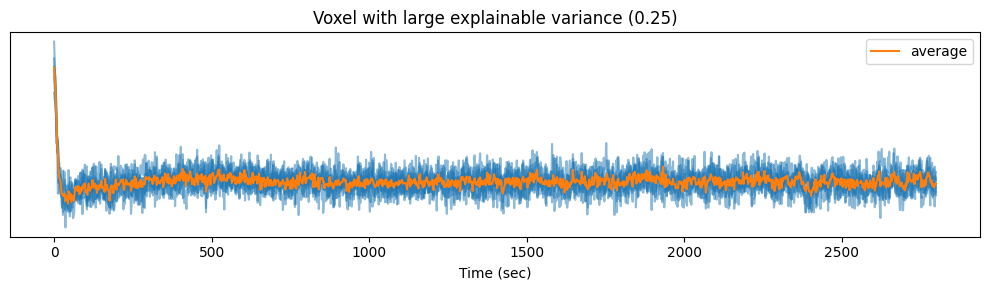

In [16]:
voxel_1 = np.argmax(ev)
time = np.arange(Y.shape[1]) * 2  # one time point every 2 seconds
plt.figure(figsize=(10, 3))
plt.plot(time, Y[:, :, voxel_1].T, color='C0', alpha=0.5)
plt.plot(time, Y[:, :, voxel_1].mean(0), color='C1', label='average')
plt.xlabel("Time (sec)")
plt.title("Voxel with large explainable variance (%.2f)" % ev[voxel_1])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

... and in a voxel with low explainable variance.

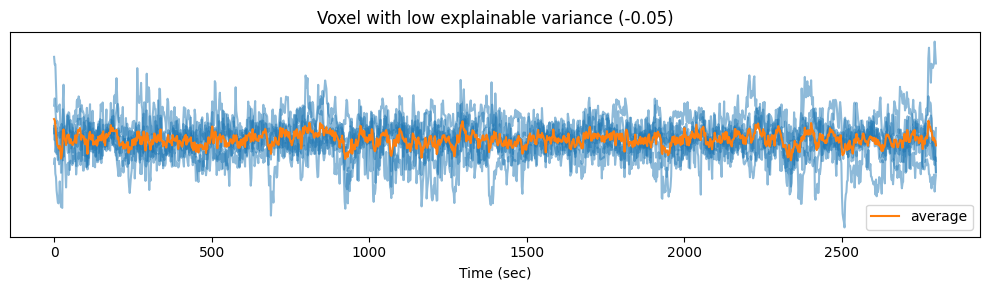

In [17]:
voxel_2 = np.argmin(ev)
plt.figure(figsize=(10, 3))
plt.plot(time, Y[:, :, voxel_2].T, color='C0', alpha=0.5)
plt.plot(time, Y[:, :, voxel_2].mean(0), color='C1', label='average')
plt.xlabel("Time (sec)")
plt.title("Voxel with low explainable variance (%.2f)" % ev[voxel_2])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

We can also plot the distribution of explainable variance over voxels.

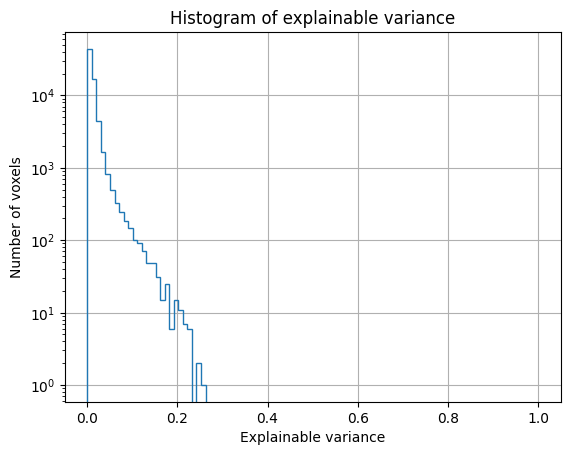

In [18]:
plt.hist(ev, bins=np.linspace(0, 1, 100), log=True, histtype='step')
plt.xlabel("Explainable variance")
plt.ylabel("Number of voxels")
plt.title('Histogram of explainable variance')
plt.grid('on')
plt.show()

---

pycortex

set up the environment variables for the pycortex

In [ ]:
import sklearn
sklearn.set_config(assume_finite=True)

---